In [1]:
from optproblems import *
from optproblems import cec2005
import numpy as np
import random
import bisect
import matplotlib.pyplot as plt
from fastprogress import progress_bar

In [2]:
def get_best_possible_fitness(problem):
    optimal_solutions = problem.get_optimal_solutions()
    an_optimal_solution = optimal_solutions[0]
    problem.evaluate(an_optimal_solution)
    return an_optimal_solution.objective_values

In [3]:
class GA:
    """
    An implementation of Genetic Algorithm, pioneered by John Holland.
    
    
    The population consists of fixed length vectors of real numbers and is initialised
    using a uniform distribution of random numbers. It uses two point crossover, tournament
    selection and Gaussian convolution for mutation.
    
    Attributes
    ----------
    problem : obj
        The cec2005 problem to be attempted
    pop_size : int
        The size of the population
    vector_length : int
        The dimensions of the problem, should be the same used when creating the problem object 
    tournament_size: int, optional
        The number of individuals competing in each tournament
    mutation_rate: float, optional
        The likelyhood of mutation for each child
    mutation_scale: int, optional
        The size of the mutation used. i.e the standard deviation of the gaussian

    Public Methods
    -------
    evolve(num_iterations)
        Evoles the population for a number of given iterations
    """
    
    def __init__(self, problem, pop_size, vector_length, tournament_size=2, mutation_rate=0.3, mutation_scale=12):
        self.problem = problem
        self.vector_length = vector_length
        self.pop_size = pop_size
        self.tournament_size = tournament_size
        self.mutation_rate = mutation_rate
        self.mutation_scale = mutation_scale
        self.current_population = np.random.rand(self.pop_size, self.vector_length)
        
    def evolve(self, num_iterations=200):
        """Evolves the population for a given number of iterations

        Parameters
        ----------
        num_iterations : int, optional
            The number of generations before stopping evolving
        
        Returns
        -------
        results : list
            A list of the best fitness at each generation
        found_global_min_at : int
            The position at which the global min was found at, return -1 if not found
        """
        results = []
        found_global_min_at = -1
        best_possible_fitness = get_best_possible_fitness(self.problem)
        for i in range(num_iterations):
            best_index, fitnesses = self.find_current_best(self.current_population)
            results.append(fitnesses[best_index])
            if math.isclose(best_possible_fitness, fitnesses[best_index], rel_tol=1e-1):
                if found_global_min_at == -1:
                    found_global_min_at = i
            self.current_population = self.update_population(fitnesses)
        return results, found_global_min_at
        
    def update_population(self, fitnesses):
        """Performs one generational update of Genetic Algorithm"""
        next_population = np.empty((self.pop_size, self.vector_length))
        for i in range(int(self.pop_size / 2)):
            parent_a = self.tournament_select_with_replacement(self.current_population)
            parent_b = self.tournament_select_with_replacement(self.current_population)
            child_a, child_b = self.crossover(parent_a, parent_b)
            next_population[i] = self.mutate(child_a)
            position_child_b = i + (self.pop_size / 2)
            next_population[int(position_child_b)] = self.mutate(child_b)
            next_population = np.clip(next_population, self.problem.min_bounds, self.problem.max_bounds)
        return next_population

    def assess_fitness(self, individual):
        """Determines the fitness of an individual using the given problem"""
        solution = Individual(individual)
        self.problem.evaluate(solution)
        return solution.objective_values

    def find_current_best(self, population):
        """Evaluates a given population and returns the fittest individual"""
        fitnesses = [self.assess_fitness(x) for x in population]
        best_value = min(fitnesses)
        best_index = fitnesses.index(best_value)
        return best_index, fitnesses

    def tournament_select_with_replacement(self, population):
        """Competes a number of challengers and returns the fittest one"""
        challengers_indexes = np.random.choice(population.shape[0], self.tournament_size, replace=True)
        challengers = population[challengers_indexes]
        best_index, _ = self.find_current_best(challengers)
        return challengers[best_index]

    def crossover(self, parent_a, parent_b):
        """Performs two point crossover on two parents"""
        l = parent_a.shape[0]
        c, d = random.randint(0, l), random.randint(0, l)
        
        # Flip if c greater than d
        if (c > d): d, c = c, d 
        if (c == d): d += 1
        temp = np.copy(parent_a)
        child_a = np.concatenate([parent_a[0:c], parent_b[c:d], parent_a[d:]])
        child_b = np.concatenate([parent_b[0:c], temp[c:d], parent_b[d:]]) 
        return child_a, child_b

    def mutate(self, child):
        """May mutate a child using Gaussian convolution"""
        if self.mutation_rate >= random.uniform(0, 1):
            size = self.current_population.shape[1]
            mutation_value = np.random.normal(0, self.mutation_scale, size)
            child = child + mutation_value
        return child


In [40]:

class Particle:
    """
    An Particle used in PSO.
        
    Attributes
    ----------
    problem : obj
        The cec2005 problem to be attempted
    velocity : nparray
        The current velocity of the particle
    position : nparray
        The current position of the particle, used as the solution for the problem given
    fittest_position : nparray
        The fittest position this particle has seen.
    
    Public Methods
    -------
    assess_fitness()
        Determines the fitness of the particle using the given problem
    update(fittest_informant, global_fittest)
        Updates the velocity and position of the particle using the PSO update algorithm
    """
    
    def __init__(self, problem, velocity, position):
        self.velocity = velocity
        self.position = position
        self.fittest_position = position
        self.problem = problem

    def assess_fitness(self): 
        """Determines the fitness of the particle using the given problem"""
        self.position = np.clip(self.position, self.problem.min_bounds, self.problem.max_bounds)
        return Particle.evaluate_position(self.position, self.problem)
    
    def update(self, fittest_informant, global_fittest):
        """ Updates the velocity and position of the particle using the PSO update algorithm"""
        beta = 2.0
        gamma = 0.9
        delta = 0.0
        epsilon = 1.0
        alpha = 0.7
        cognitive = random.uniform(0, beta)
        social = random.uniform(0, gamma)
        glob = random.uniform(0, delta)
        self.velocity = (alpha * self.velocity 
                        + cognitive * (self.fittest_position - self.position)
                        + social * (fittest_informant.fittest_position - self.position)
                        + glob * (global_fittest.fittest_position - self.position))
        previous_fitness = self.assess_fitness() 
        self.position += self.velocity * epsilon
        current_fitness = self.assess_fitness()
        if (current_fitness < previous_fitness):
            self.fittest_position = self.position
        
    @staticmethod 
    def evaluate_position(position, problem):
        """Determines the fitness of the position using the given problem"""
        solution = Individual(position)
        problem.evaluate(solution)
        return solution.objective_values

class PSO:
    """
    An implementation of Particle Swarm Optimisation, pioneered by Kennedy, Eberhart and Shi.
    
    
    The swarm consists of Particles with 2 fixed length vectors; velocity and position.
    Each velocity and position is initialised using a uniform distribution. Each particle has a
    number of informants which are randomly chosen at each run. Each particle is it’s own
    informant.
    
    Attributes
    ----------
    problem : obj
        The cec2005 problem to be attempted
    swarm_size : int
        The size of the swarm
    vector_length : int
        The dimensions of the problem, should be the same used when creating the problem object 
    num_informants: int, optional
        The number of informants used for social component in particle velocity update 

    Public Methods
    -------
    improve(num_iterations)
        Improves the population for a number of given iterations
    """
    def __init__(self, problem, swarm_size, vector_length, num_informants=2):
        self.swarm_size = swarm_size
        self.num_informants = num_informants
        self.problem = problem
        self.swarm = [Particle(self.problem, np.random.rand(vector_length), np.random.rand(vector_length))
                      for x in range(swarm_size)]
        self.global_fittest = np.random.choice(self.swarm, 1)[0]
    
    def find_current_best(self, swarm):
        """Evaluates a given swarm and returns the fittest particle based on their best previous position"""
        fitnesses = [Particle.evaluate_position(x.fittest_position, self.problem) for x in swarm]
        best_value = min(fitnesses)
        best_index = fitnesses.index(best_value)
        return swarm[best_index], fitnesses
    
    def update_swarm(self):
        """Update each particle in the swarm"""
        for particle in self.swarm:
            informants = np.random.choice(self.swarm, self.num_informants)
            if (particle not in informants):
                np.append(informants, particle)
            fittest_informant, _ = self.find_current_best(informants)
            
            particle.update(fittest_informant, self.global_fittest)
    
    def improve(self, num_iterations=200):
        """Improves the population for a given number of iterations.

        Parameters
        ----------
        num_iterations : int, optional
            The number of iterations before stopping improving
        
        Returns
        -------
        results : list
            A list of the best fitness at each generation
        found_global_min_at : int
            The position at which the global min was found at, return -1 if not found
        """
        best_possible_fitness = get_best_possible_fitness(self.problem)
        fitnesses = []
        found_global_min_at = -1
        for i in range(num_iterations):
            fittest, _ = self.find_current_best(self.swarm)
            global_fittest_fitness = self.global_fittest.assess_fitness()
            if (fittest.assess_fitness() < global_fittest_fitness):
                self.global_fittest = fittest
            fitnesses.append(global_fittest_fitness)
            self.update_swarm()
            if math.isclose(best_possible_fitness, global_fittest_fitness, rel_tol=1e-1) :
                if found_global_min_at == -1:
                    found_global_min_at = i
        return fitnesses, found_global_min_at

    

## Compare 

In [41]:
size, num_iterations = 50, 200
vector_length = 10
problem = cec2005.F1(vector_length)
pso_fitnesses = []
pso_found_global_best_results = []
ga_fitnesses = []
ga_found_global_best_results = []
for j in progress_bar(range(10)):
    pso = PSO(problem, size, vector_length)
    fitness, pso_found_global_best = pso.improve(num_iterations)
    pso_found_global_best_results.append(pso_found_global_best)
    pso_fitnesses.append(fitness)
    
    ga = GA(problem, size, vector_length)
    fitness, ga_found_global_best = ga.evolve(num_iterations)
    ga_found_global_best_results.append(ga_found_global_best)
    ga_fitnesses.append(fitness)
    


In [42]:
def get_mean(tests):
    return np.mean(np.array(tests), axis=0)

pso_mean_fitnesses = get_mean(pso_fitnesses)
ga_mean_fitnesses = get_mean(ga_fitnesses)

best_possible_fitness = get_best_possible_fitness(problem)
best_fitnesses = np.full_like(pso_mean_fitnesses, best_possible_fitness)


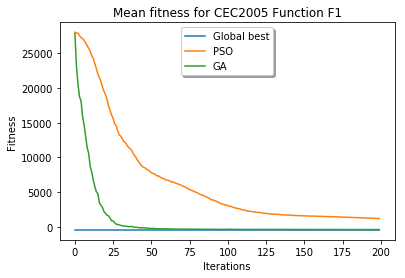

In [45]:
fig, ax = plt.subplots()
ax.plot(best_fitnesses, label="Global best")
ax.plot(pso_mean_fitnesses,  label="PSO")
ax.plot(ga_mean_fitnesses, label="GA")
title = 'F1'
# ax.set_yscale('log')
plt.title(f'Mean fitness for CEC2005 Function {title}')
legend = ax.legend(loc='upper center', shadow=True)
# plt.ylim(0,1)
plt.ylabel('Fitness')
plt.xlabel('Iterations')
plt.show()